In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, visualize_prior, model_graph, traceplot, plot_gps_components, plot_elbo
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# No trend

In [2]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [3]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [4]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000)

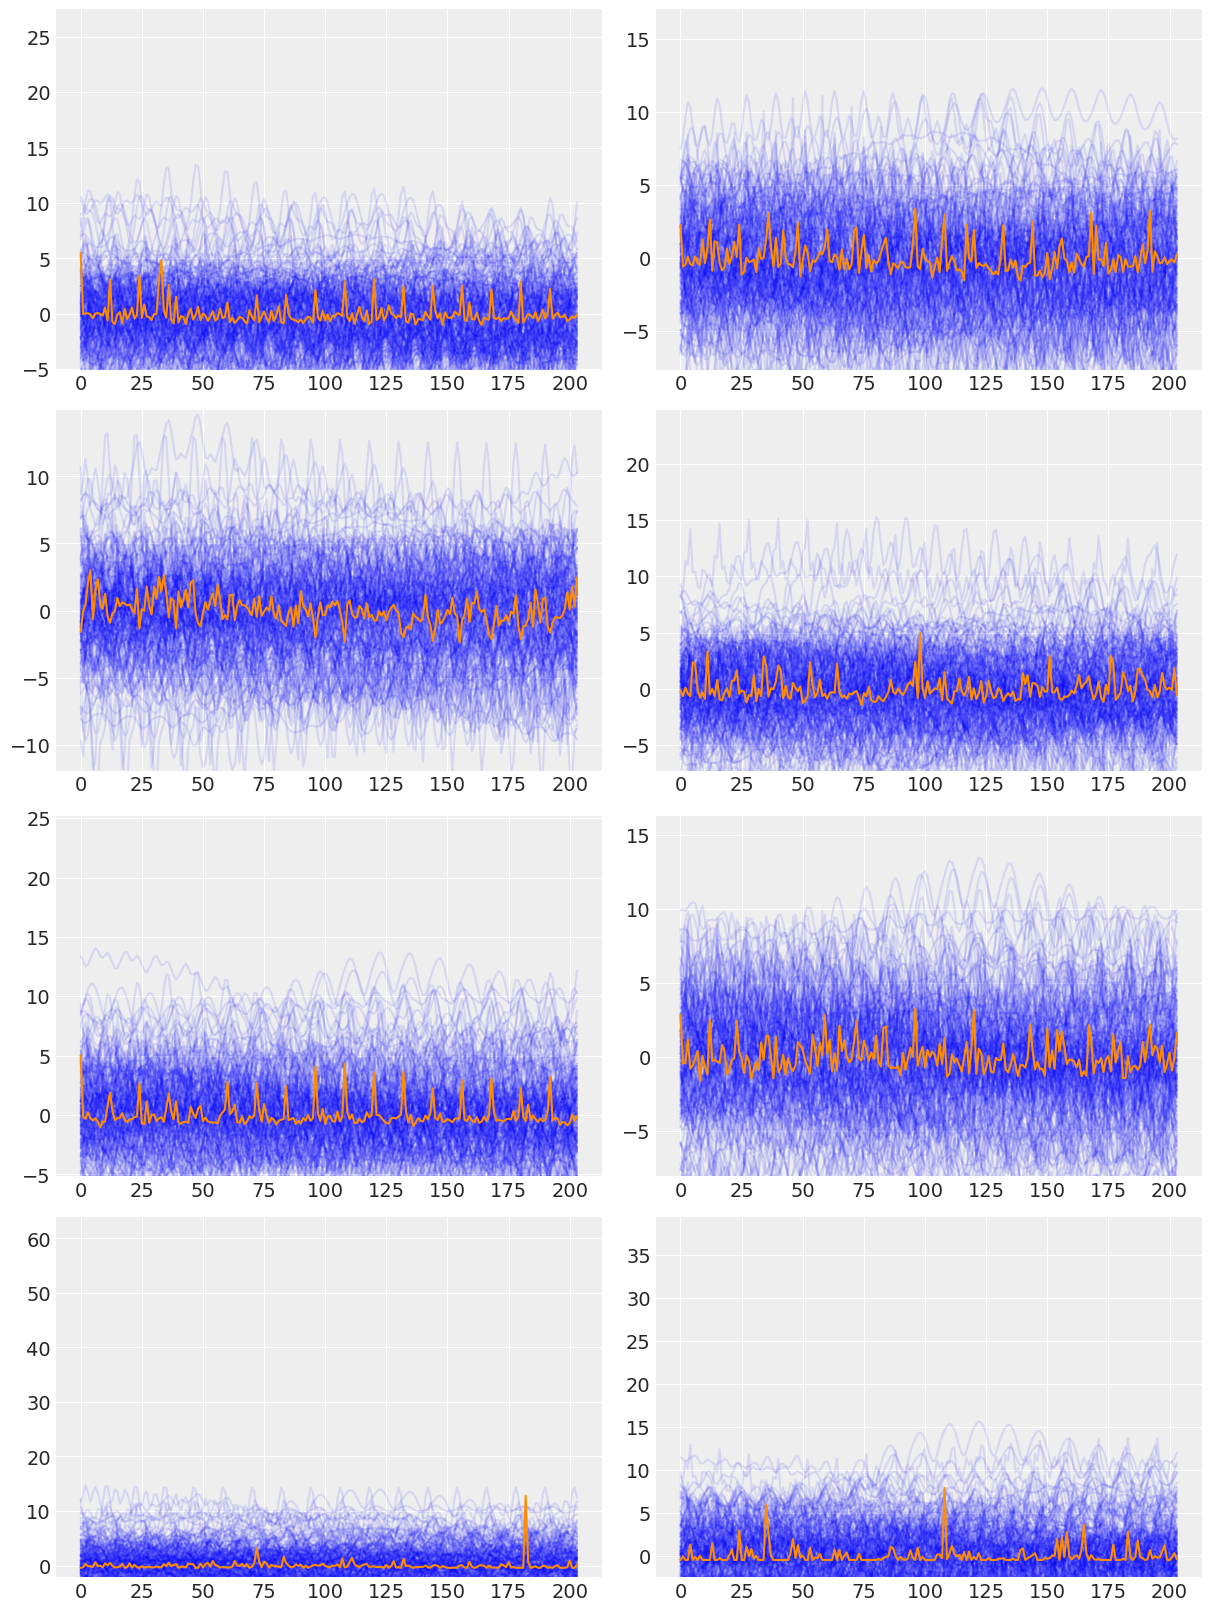

In [5]:
m.prior_predictive_checks()
visualize_prior(groups, m.prior_checks, 8)

In [6]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.935e+05


Sampling...


In [7]:
m.predict()

Sampling...


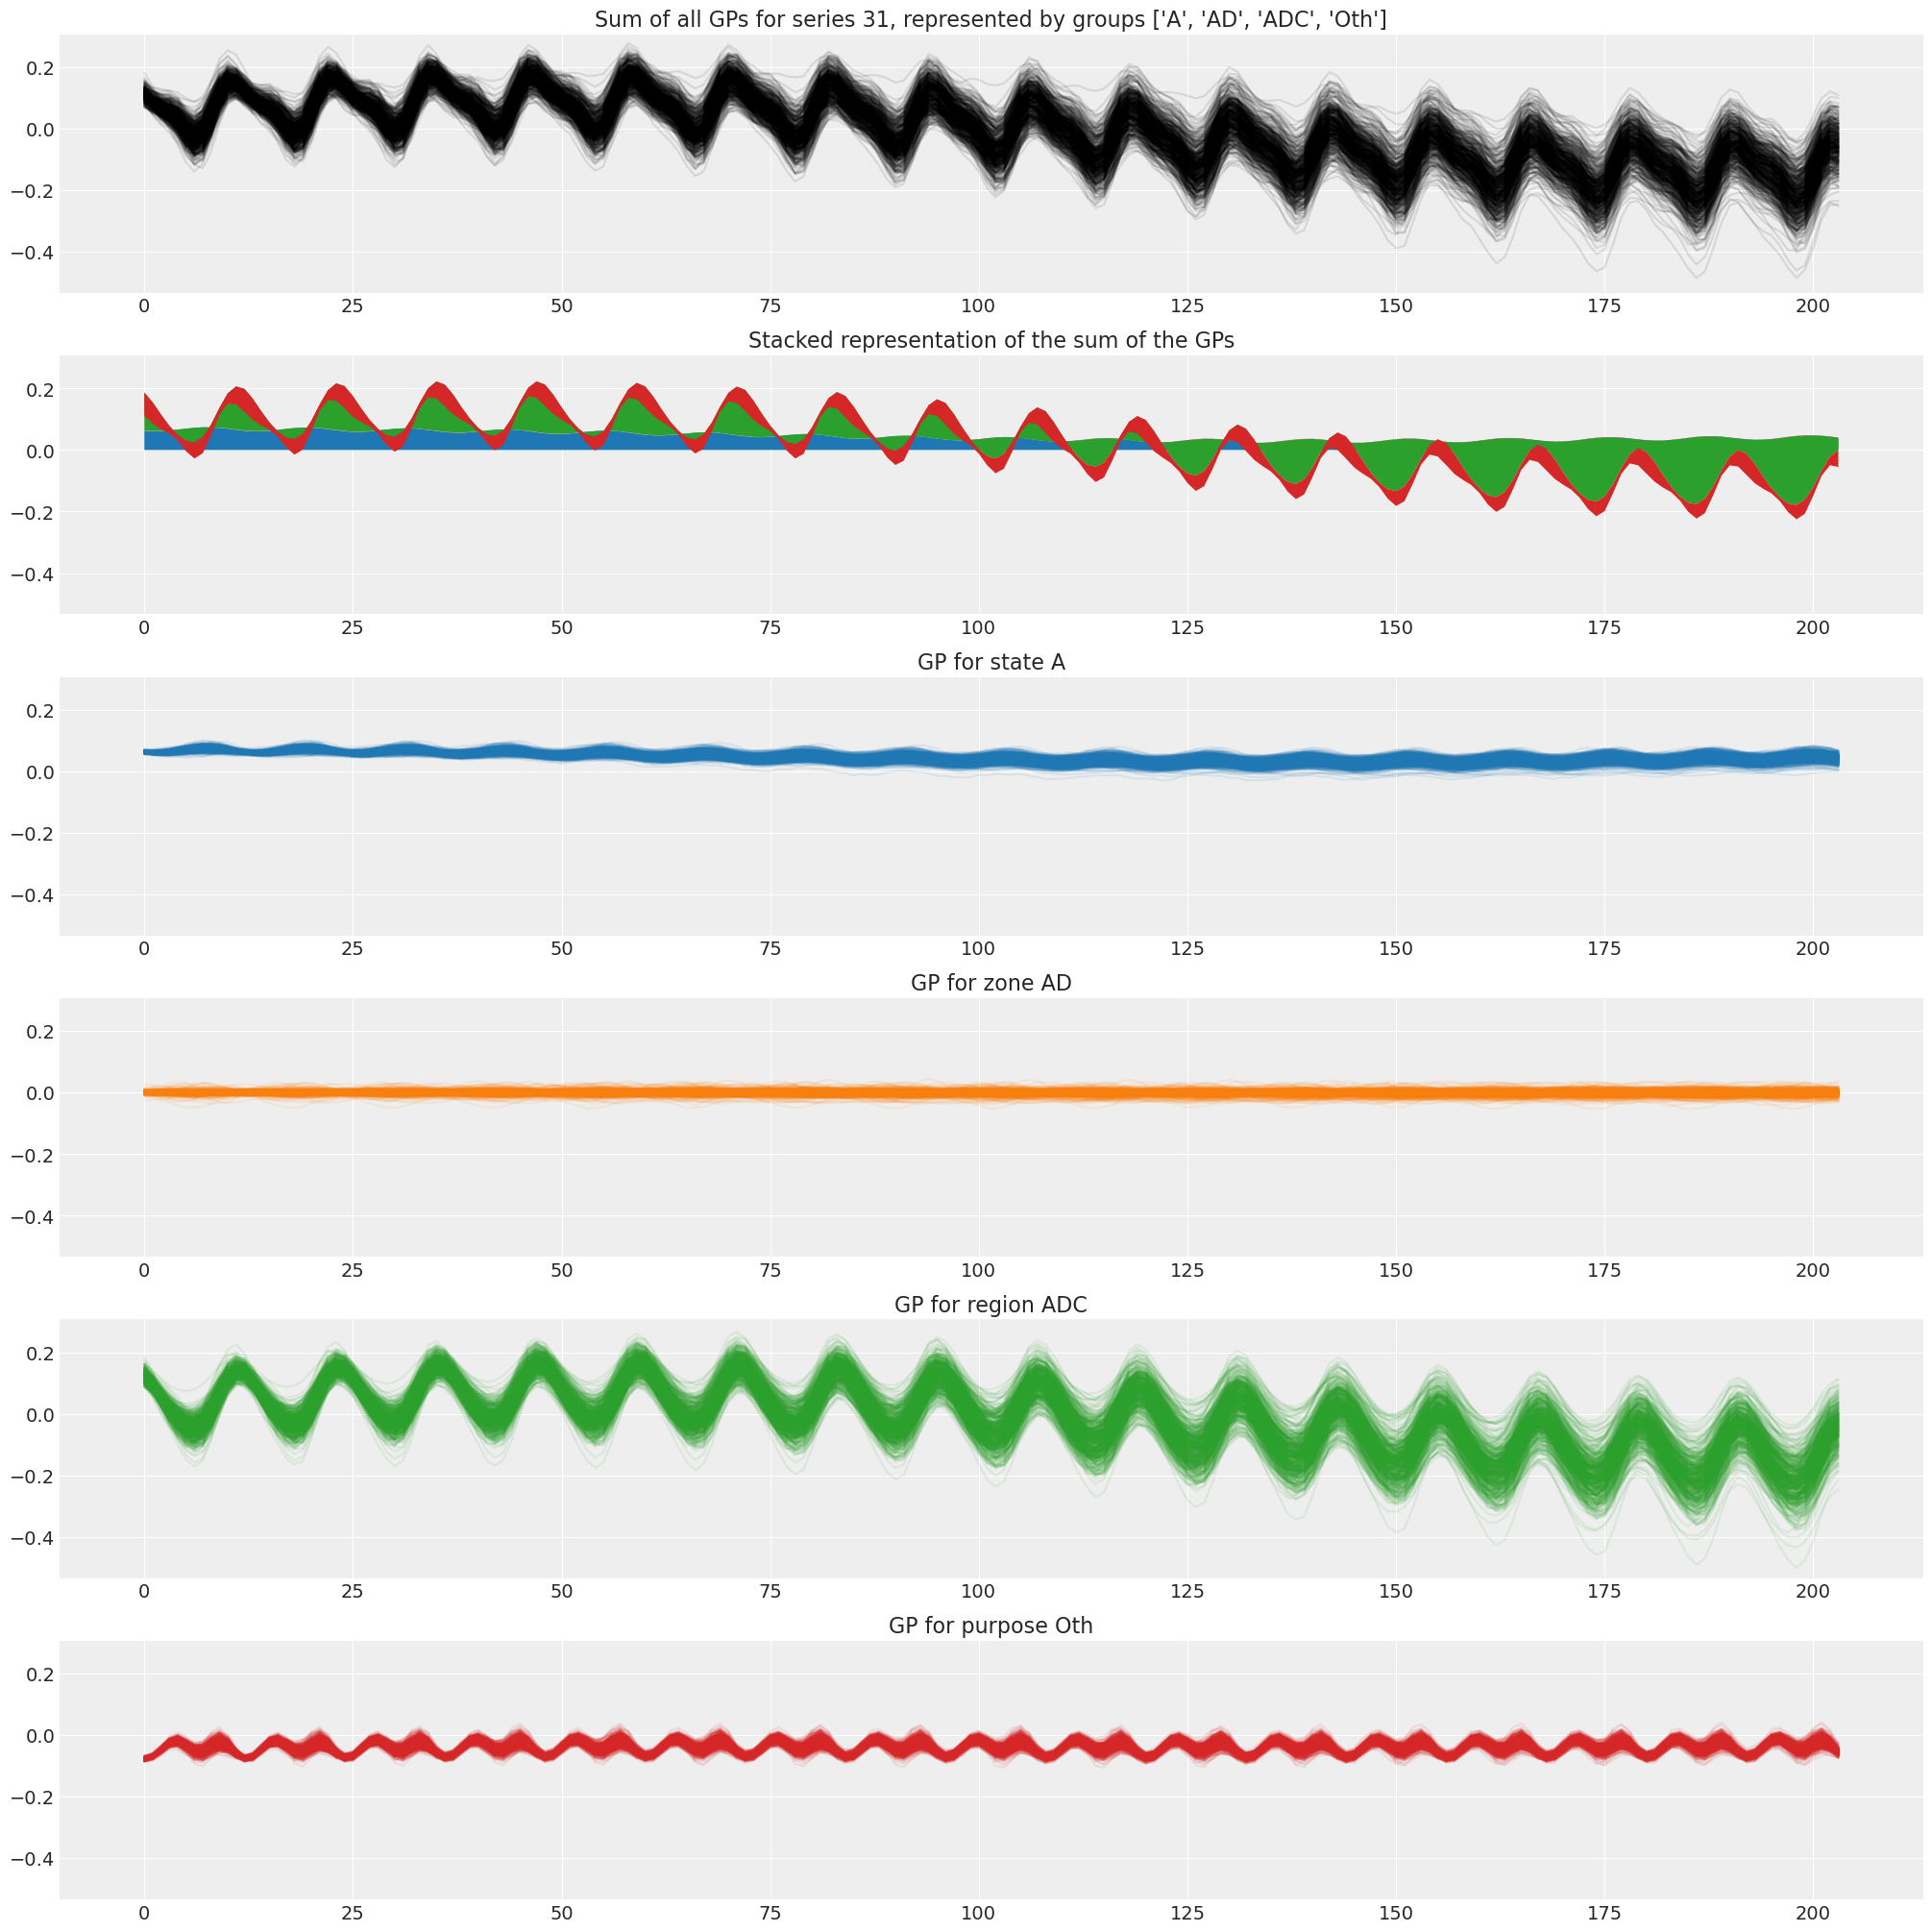

In [9]:
plot_gps_components(series=31, groups=m.g, trace=m.trace_vi_samples)

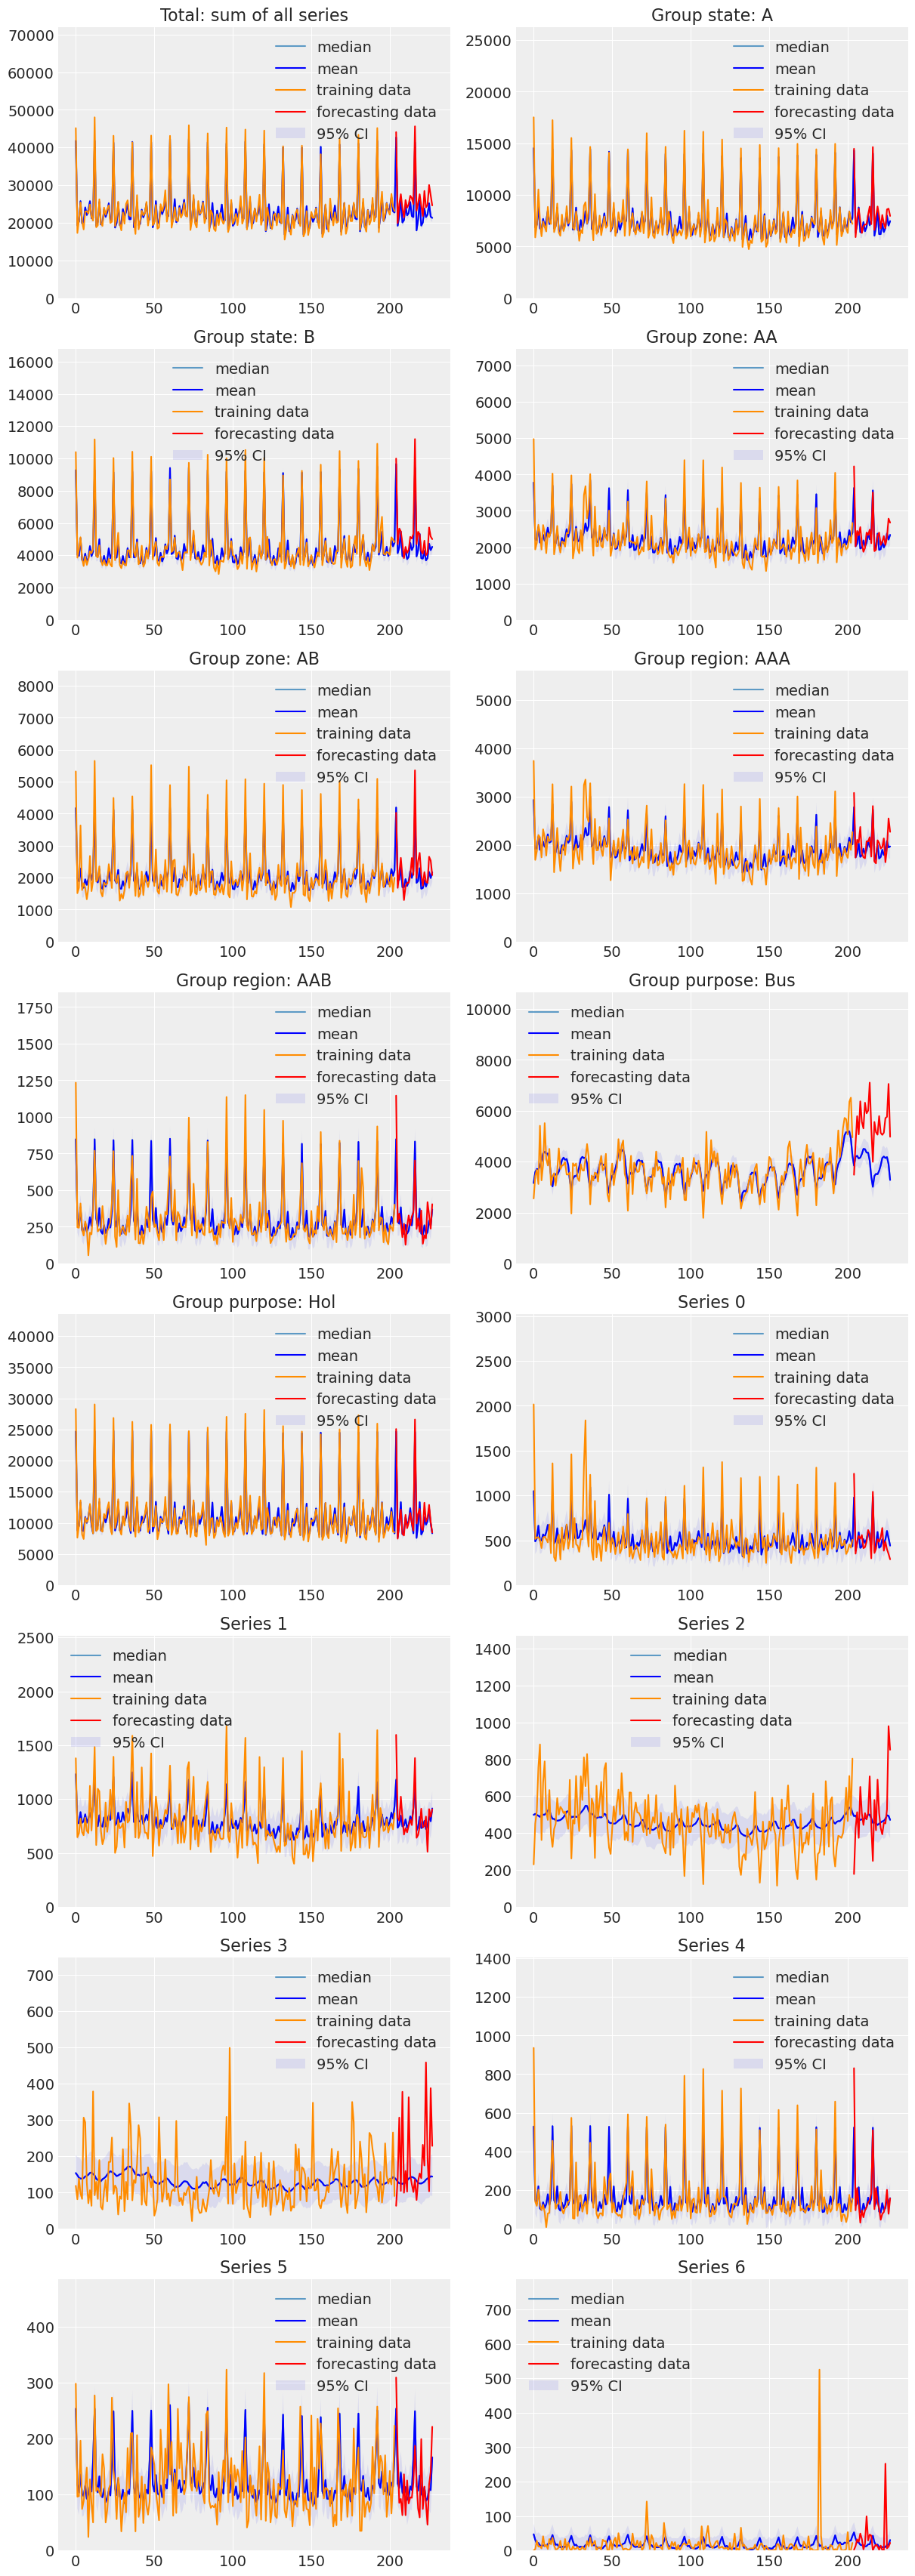

In [10]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [11]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Outside Piecewise Linear

In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing import generate_groups_data_matrix_minibatch, generate_groups_data_matrix, data_transform

class LogLinear(pm.gp.mean.Mean):
    # Log linear mean function to get diminishing returns on the GP mean functions
    # -> adding 1 to avoid inf when X = 0
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(tt.log(X+1), self.b) + self.a)


class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        
        if not self.minibatch:
            # with minibatch X is already a theano variable
            X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 a,
                 changepoints,
                 groups):
        self.a = a
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise + self.a


class HGPforecaster:

    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        log_lin_mean=None,
        likelihood='normal',
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool=False,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.likelihood = likelihood
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool = partial_pool
        self.partial_pool_mean = partial_pool

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.log_lin_mean = log_lin_mean

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        if self.likelihood == 'normal':
            # if likelihood is normal standardize data
            self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            if self.likelihood=='poisson':
                pass
            else:
                # In the case of a normal likelihood we need to define sigma
                self.priors['sigma'] = pm.HalfNormal(
                    'sigma',
                    0.001,
                    shape = self.g['train']['s'])

            if self.piecewise_out:
                if self.likelihood == 'poisson':
                    pass
                else:
                    self.priors["k"] = pm.Normal(
                        'k',
                        0.0,
                        0.1,
                        shape = self.g['train']['s'])
                    self.priors["m"] = pm.Normal(
                        'm', 
                        0.0,
                        0.1,
                        shape = self.g['train']['s'])

                    self.priors["b"] = pm.Normal(
                        'b', 
                        0.,
                        0.1,
                        shape = (self.changepoints.shape[0], self.g['train']['s']))
                    
                    self.priors['a'] = pm.Normal(
                        'a',
                        0.1,
                        shape = self.g['train']['s'])

            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                if self.partial_pool:
                    pass

                else:
                    # Initialization not using partial pooling

                    # Parameters expQuad kernel
                    self.priors["l_t_%s" %group] = pm.InverseGamma(
                        'l_t_%s' %group, 
                        4, 
                        self.g['train']['n'], 
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_t_%s" %group] = pm.HalfNormal(
                        'eta_t_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])

                    # Parameters periodic kernel
                    self.priors["l_p_%s" %group] = pm.HalfNormal(
                        'l_p_%s' %group, 
                        0.5,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_p_%s" %group] = pm.HalfNormal(
                        'eta_p_%s' %group, 
                        1.5, 
                        shape = self.g['train']['groups_n'][group])

                    # Parameters white noise kernel
                    self.priors["sigma_%s" %group] = pm.HalfNormal(
                        'sigma_%s' %group, 
                        0.001,
                        shape = self.g['train']['groups_n'][group])





    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group


                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP with specific parameters per group
                    cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                            + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                            + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    pass
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    # defining a poisson likelihood
                    if self.piecewise_out:
                        pass
                    else:
                        # not using a piecewise linear function outside of the GPs
                        self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'])
                else:
                    if self.piecewise_out:
                        # normal likelihood with a piecewise function summed
                        piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                            m = self.priors["m"],
                                                            b = self.priors['b'],
                                                            a = self.priors['a'],
                                                            changepoints = self.changepoints,
                                                            groups = self.g).build(self.X)
                        self.y_pred = pm.Normal('y_pred', 
                            mu=self.f + piece, 
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])
                    else:
                        # normal likelihood without minibatch
                        self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'],
                                observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.likelihood=='poisson':
                # defining a poisson likelihood
                if self.piecewise_out:
                    pass
            else:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                        m = self.priors["m"],
                                                        b = self.priors['b'],
                                                        a = self.priors['a'],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(self.X)
                    self.prior_like = pm.Normal('prior_like', 
                        mu=piece + self.f, 
                        sd=self.priors['sigma'],
                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
                else:
                    pass
            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            if self.likelihood == 'normal':
                self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.likelihood=='poisson':
                pass
            else:
                if self.piecewise_out:
                    piece = OutPiecewiseLinearChangepoints(k = self.priors['k'],
                                                m = self.priors['m'],
                                                b = self.priors['b'],
                                                a = self.priors['a'],
                                                changepoints = self.changepoints,
                                                groups = self.g).build(X_new)

                    y_pred_new = pm.Normal("y_pred_new", 
                                    mu=f_ + piece,
                                    sd=self.priors['sigma'],
                                    shape=(n_new, self.g['predict']['s']))
                else:
                    pass
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                pass
        # backtransform the data and predictions to the original scale
        if self.likelihood == 'normal':
            if self.minibatch:   
                self.g['train']['data'] = self.g['train']['full_data'] 
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
            else:
                self.g = self.dt.inv_transf_train()
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [3]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [4]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [5]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  piecewise_out=True,
                  changepoints = 4)

In [6]:
#m.prior_predictive_checks()
#visualize_prior(groups, m.prior_checks, 8)

In [7]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.6717e+06


Sampling...


In [8]:
m.predict()

Sampling...


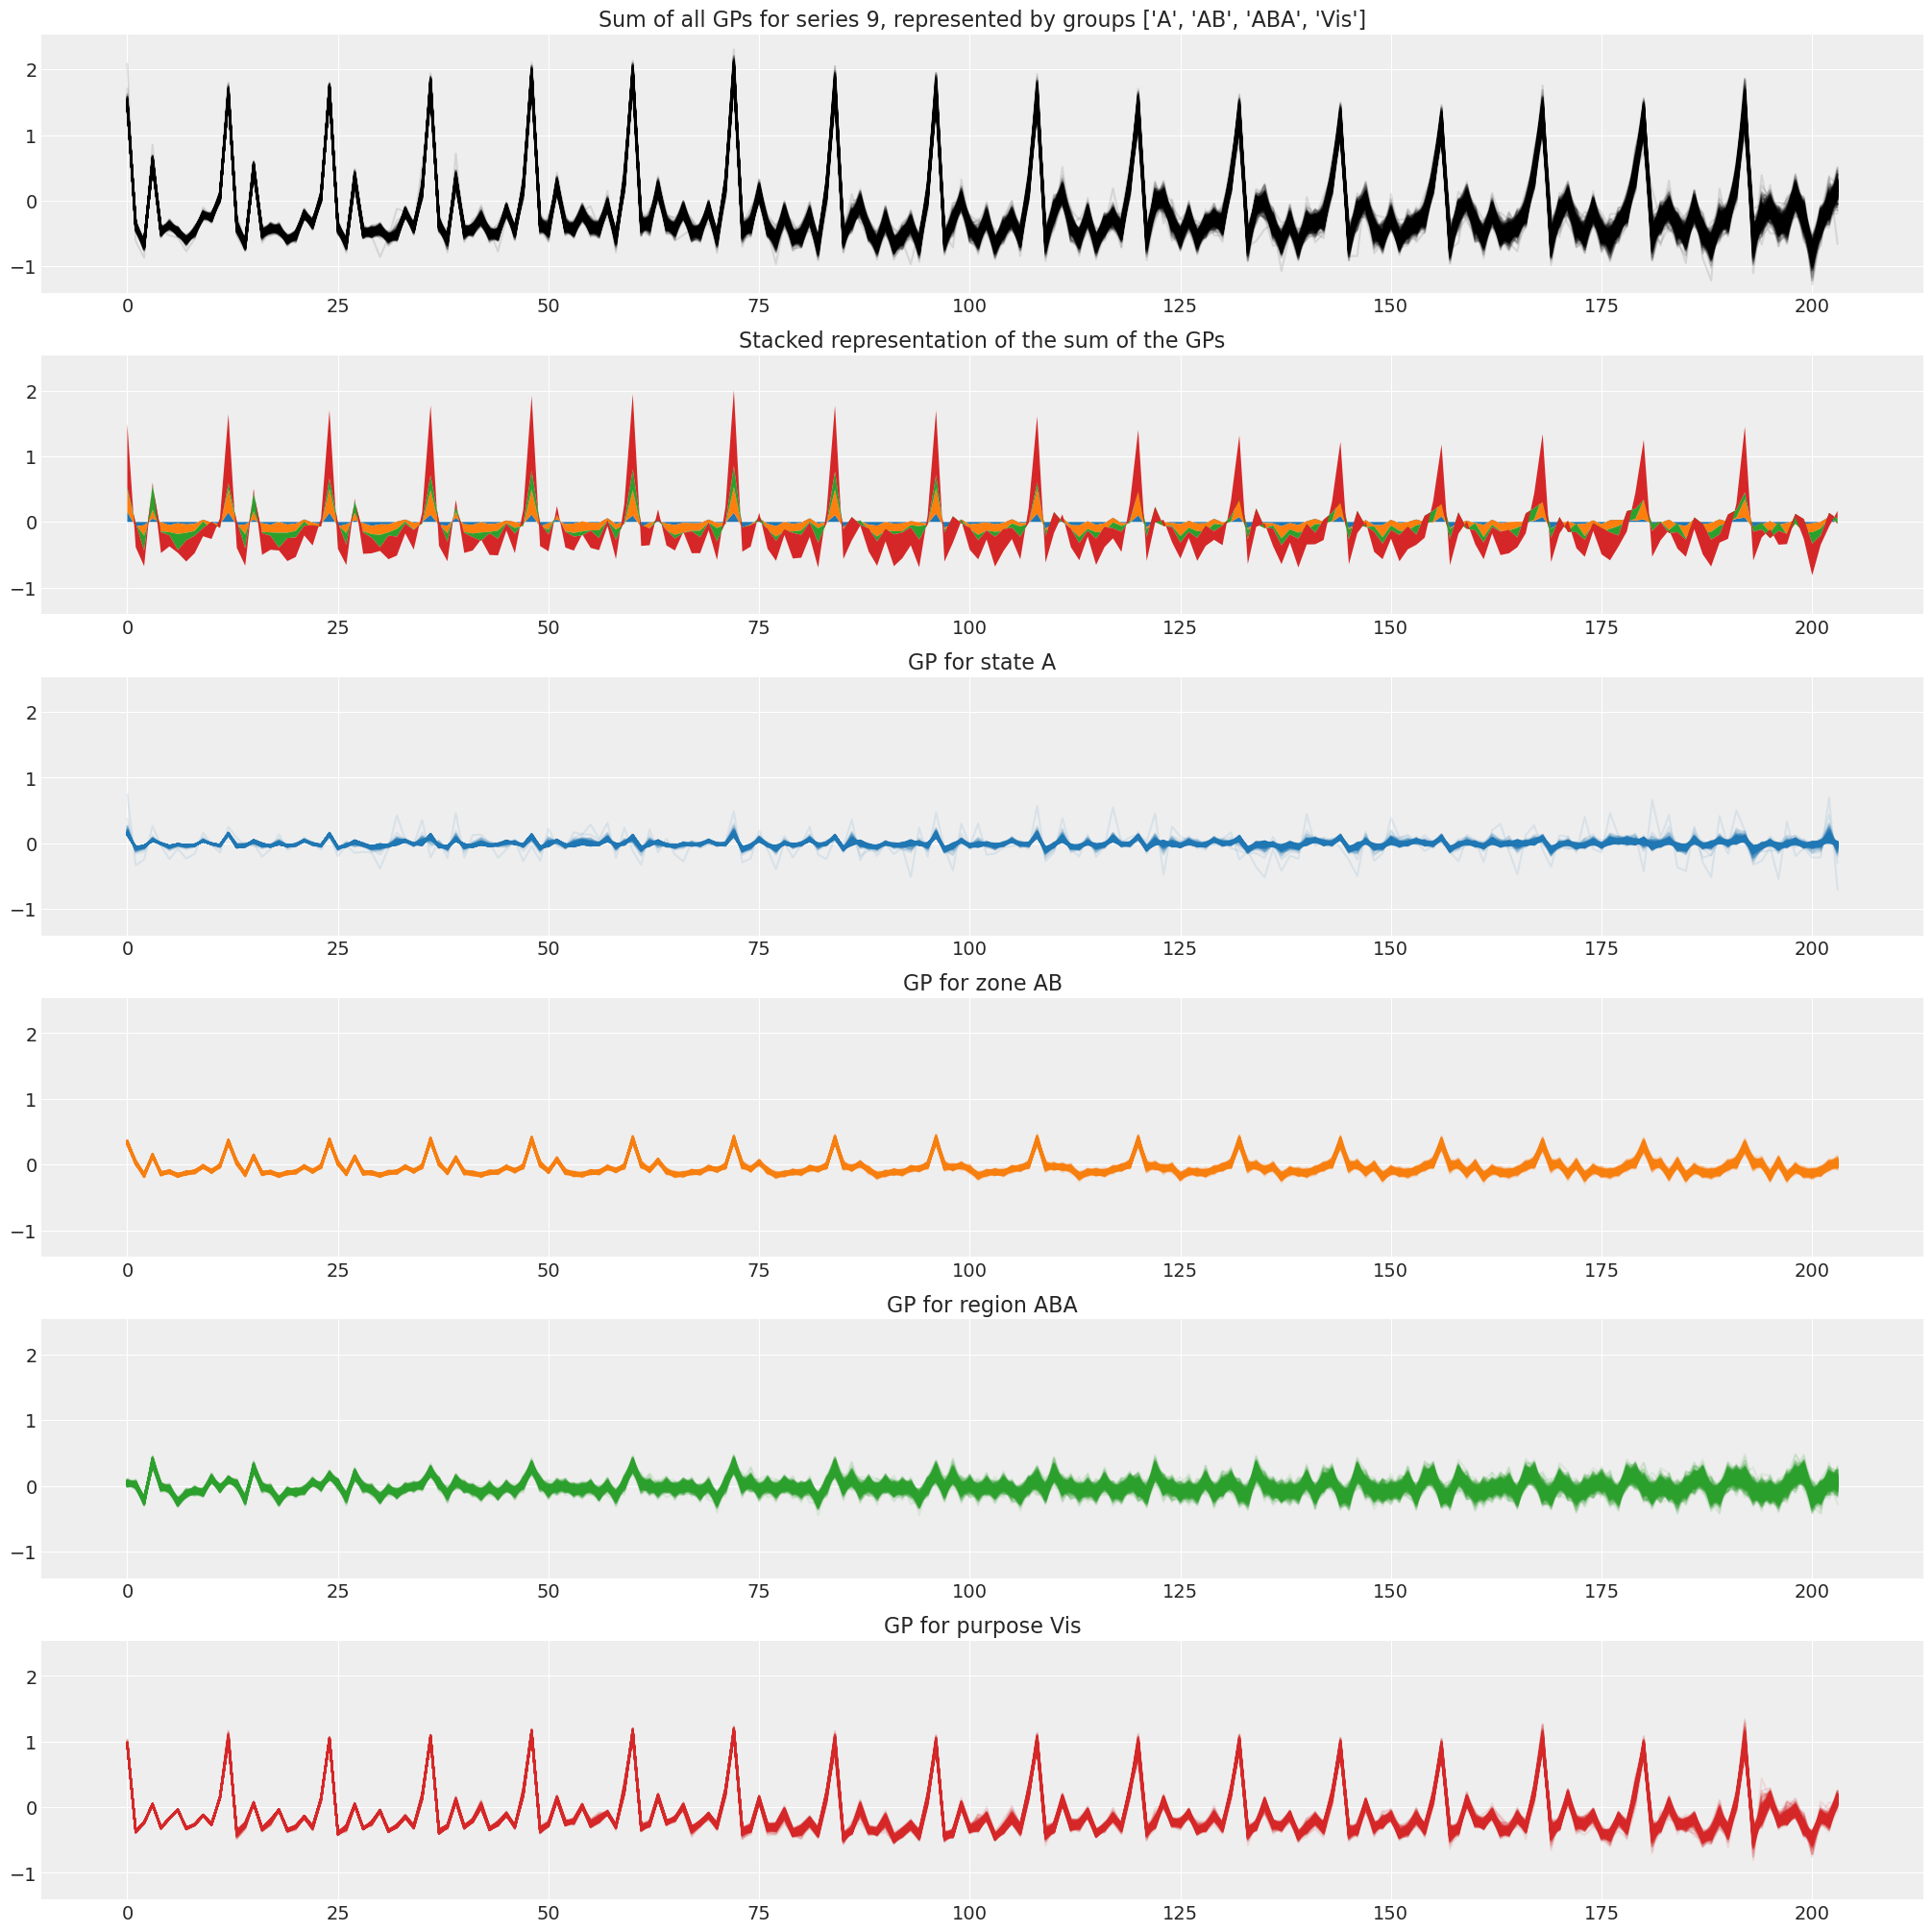

In [9]:
plot_gps_components(series=9, groups=m.g, trace=m.trace_vi_samples)

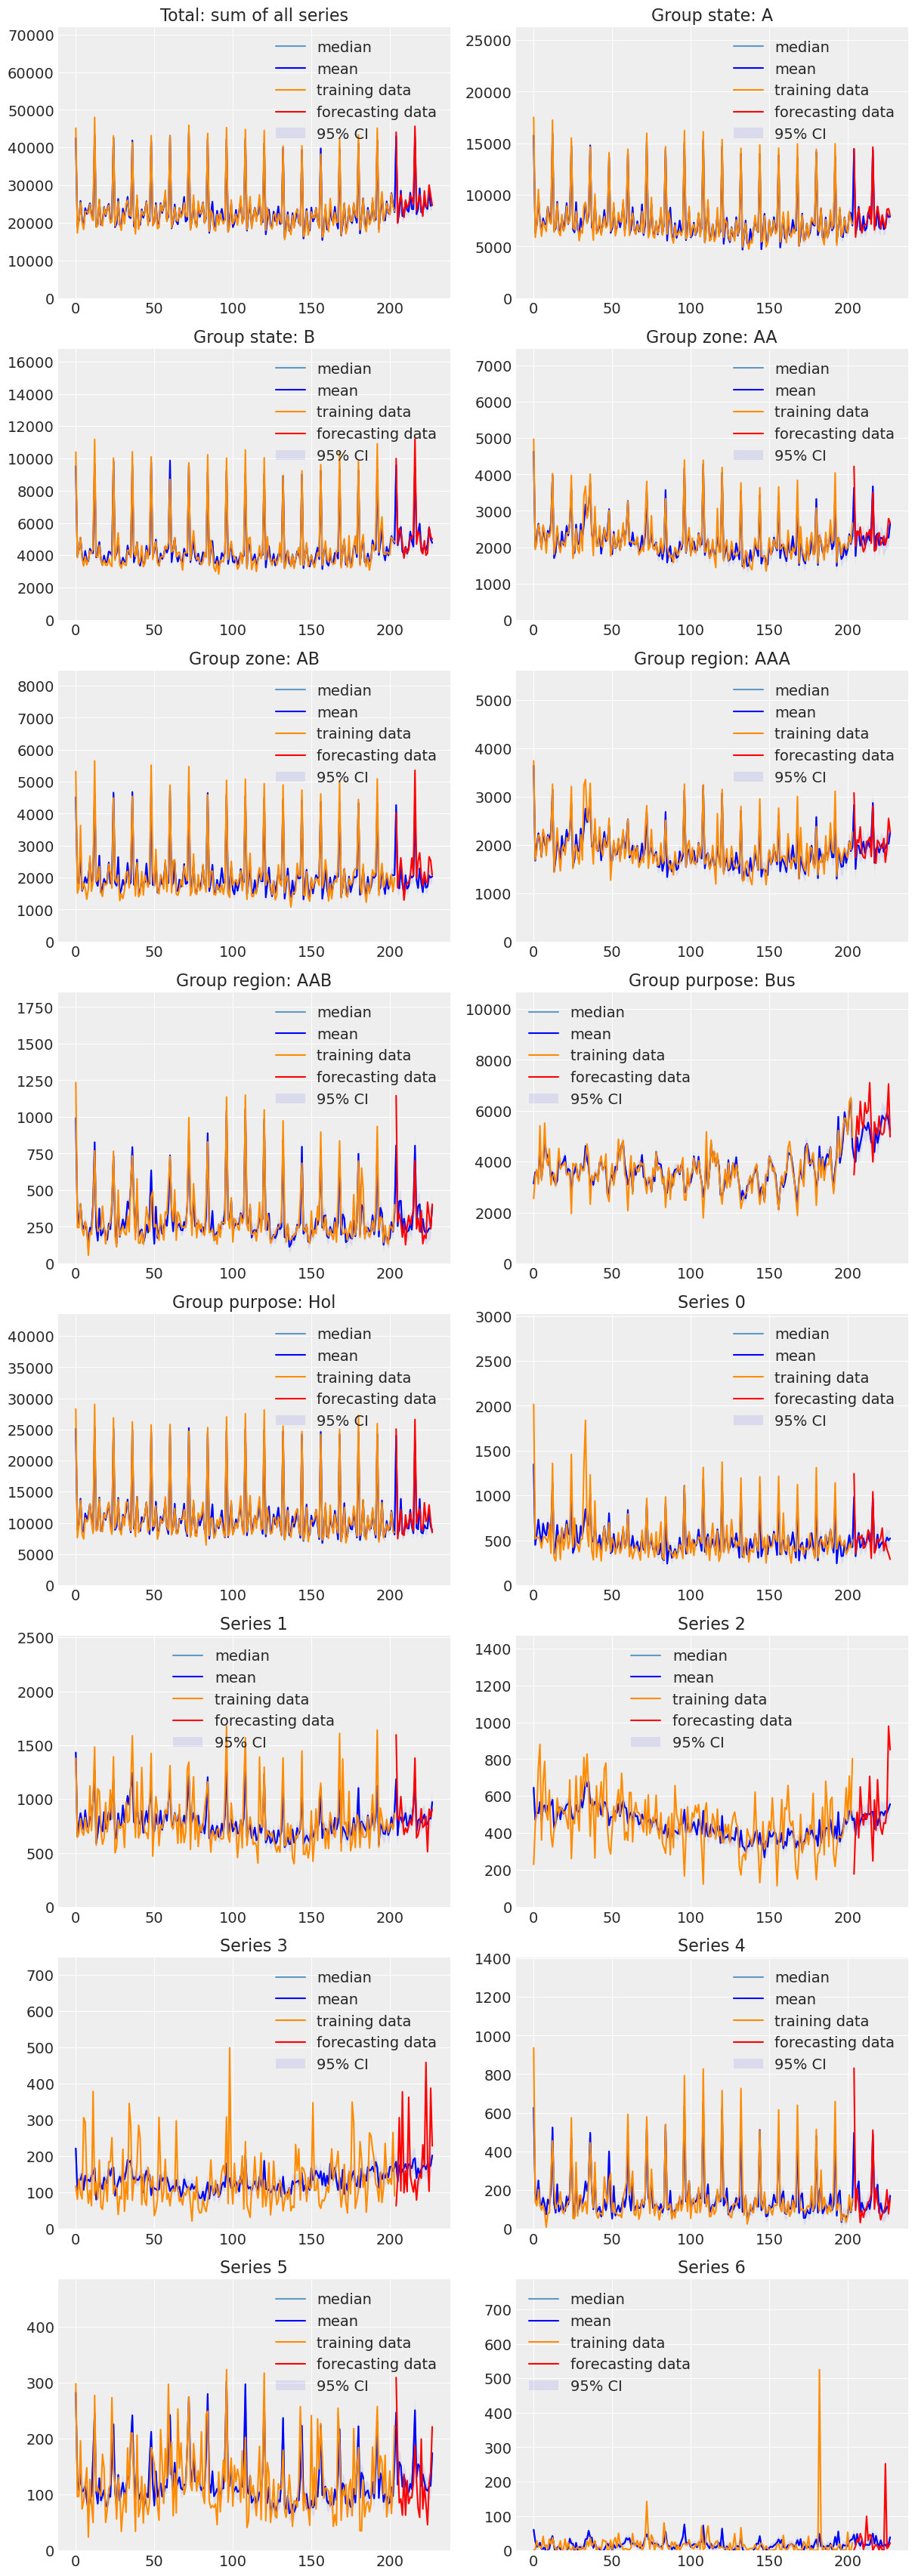

In [10]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [11]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Minibatch - Outside Piecewise Linear

In [ ]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [ ]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

In [ ]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  minibatch=[100,20])

In [ ]:
m.fit_vi()

In [ ]:
m.predict()

In [ ]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Outside Piecewise Linear w/ Partial pooling

In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing import generate_groups_data_matrix_minibatch, generate_groups_data_matrix, data_transform

class LogLinear(pm.gp.mean.Mean):
    # Log linear mean function to get diminishing returns on the GP mean functions
    # -> adding 1 to avoid inf when X = 0
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(tt.log(X+1), self.b) + self.a)


class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        
        if not self.minibatch:
            # with minibatch X is already a theano variable
            X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 a,
                 changepoints,
                 groups):
        self.a = a
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise + self.a


class HGPforecaster:

    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        log_lin_mean=None,
        likelihood='normal',
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool=False,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.likelihood = likelihood
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool = partial_pool
        self.partial_pool_mean = partial_pool

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.log_lin_mean = log_lin_mean

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        if self.likelihood == 'normal':
            # if likelihood is normal standardize data
            self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            if self.likelihood=='poisson':
                pass
            else:
                # In the case of a normal likelihood we need to define sigma
                self.priors['sigma'] = pm.HalfNormal(
                    'sigma',
                    0.001,
                    shape = self.g['train']['s'])

            if self.piecewise_out:
                if self.likelihood == 'poisson':
                    pass
                else:
                    for group in self.levels:
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group,
                            0.0,
                            0.1)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.1)

                        self.priors["hy_b_%s" %group] = pm.Normal(
                            'hy_b_%s' %group, 
                            0.,
                            0.1,
                            shape = (self.changepoints.shape[0],1))

                        self.priors['hy_a_%s' %group] = pm.Normal(
                            'hy_a_%s' %group,
                            0.1)
                    

                        self.priors["k_%s" %group] = pm.Normal(
                            'k_%s' %group,
                            self.priors["hy_k_%s" %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])
                        self.priors["m_%s"%group] = pm.Normal(
                            'm_%s' %group, 
                            self.priors["hy_m_%s" %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])

                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            self.priors["hy_b_%s" %group],
                            0.01,
                            shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))                            
                            
                            
                        self.priors["a_%s"%group] = pm.Normal(
                            'a_%s' %group, 
                            self.priors['hy_a_%s' %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])


            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                if self.partial_pool:
                    pass

                else:
                    # Initialization not using partial pooling

                    # Parameters expQuad kernel
                    self.priors["l_t_%s" %group] = pm.InverseGamma(
                        'l_t_%s' %group, 
                        4, 
                        self.g['train']['n'], 
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_t_%s" %group] = pm.HalfNormal(
                        'eta_t_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])

                    # Parameters periodic kernel
                    self.priors["l_p_%s" %group] = pm.HalfNormal(
                        'l_p_%s' %group, 
                        0.5,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_p_%s" %group] = pm.HalfNormal(
                        'eta_p_%s' %group, 
                        1.5, 
                        shape = self.g['train']['groups_n'][group])

                    # Parameters white noise kernel
                    self.priors["sigma_%s" %group] = pm.HalfNormal(
                        'sigma_%s' %group, 
                        0.001,
                        shape = self.g['train']['groups_n'][group])





    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group


                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP with specific parameters per group
                    cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                            + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                            + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    pass
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    # defining a poisson likelihood
                    if self.piecewise_out:
                        pass
                    else:
                        # not using a piecewise linear function outside of the GPs
                        self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'])
                else:
                    if self.piecewise_out:
                        # normal likelihood with a piecewise function summed
                        piece_={}
                        for group in self.levels:
                            piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                            m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                            b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                            a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                            changepoints = self.changepoints,
                                                            groups = self.g).build(self.X)
                        
                        piece = sum(piece_.values())
                        self.y_pred = pm.Normal('y_pred', 
                            mu=self.f + piece, 
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])
                    else:
                        # normal likelihood without minibatch
                        self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'],
                                observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.likelihood=='poisson':
                # defining a poisson likelihood
                if self.piecewise_out:
                    pass
            else:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(self.X)

                    piece = sum(piece_.values())
                    self.prior_like = pm.Normal('prior_like', 
                        mu=piece + self.f, 
                        sd=self.priors['sigma'],
                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
                else:
                    pass
            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            if self.likelihood == 'normal':
                self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.likelihood=='poisson':
                pass
            else:
                if self.piecewise_out:
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(X_new)

                    piece = sum(piece_.values())
                    y_pred_new = pm.Normal("y_pred_new", 
                                    mu=f_ + piece,
                                    sd=self.priors['sigma'],
                                    shape=(n_new, self.g['predict']['s']))
                else:
                    pass
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                pass
        # backtransform the data and predictions to the original scale
        if self.likelihood == 'normal':
            if self.minibatch:   
                self.g['train']['data'] = self.g['train']['full_data'] 
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
            else:
                self.g = self.dt.inv_transf_train()
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [3]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [4]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [5]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [6]:
#m.prior_predictive_checks()
#visualize_prior(groups, m.prior_checks, 8)

In [7]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 3.8815e+06


Sampling...


In [8]:
m.predict()

Sampling...


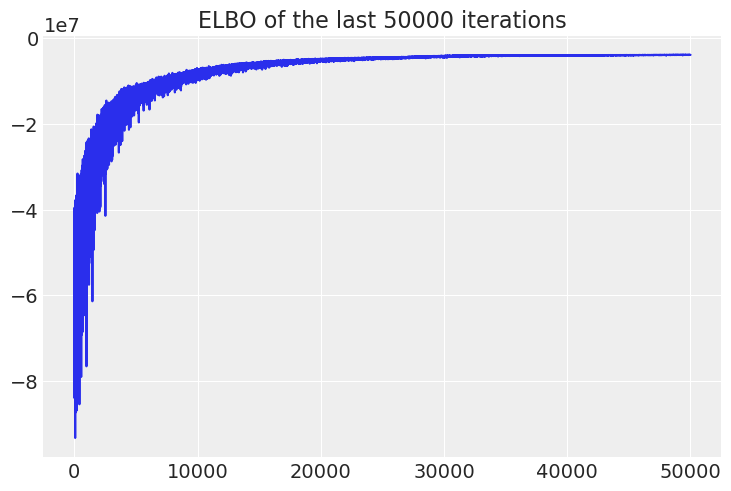

In [9]:
plot_elbo(m.trace_vi, 50000)

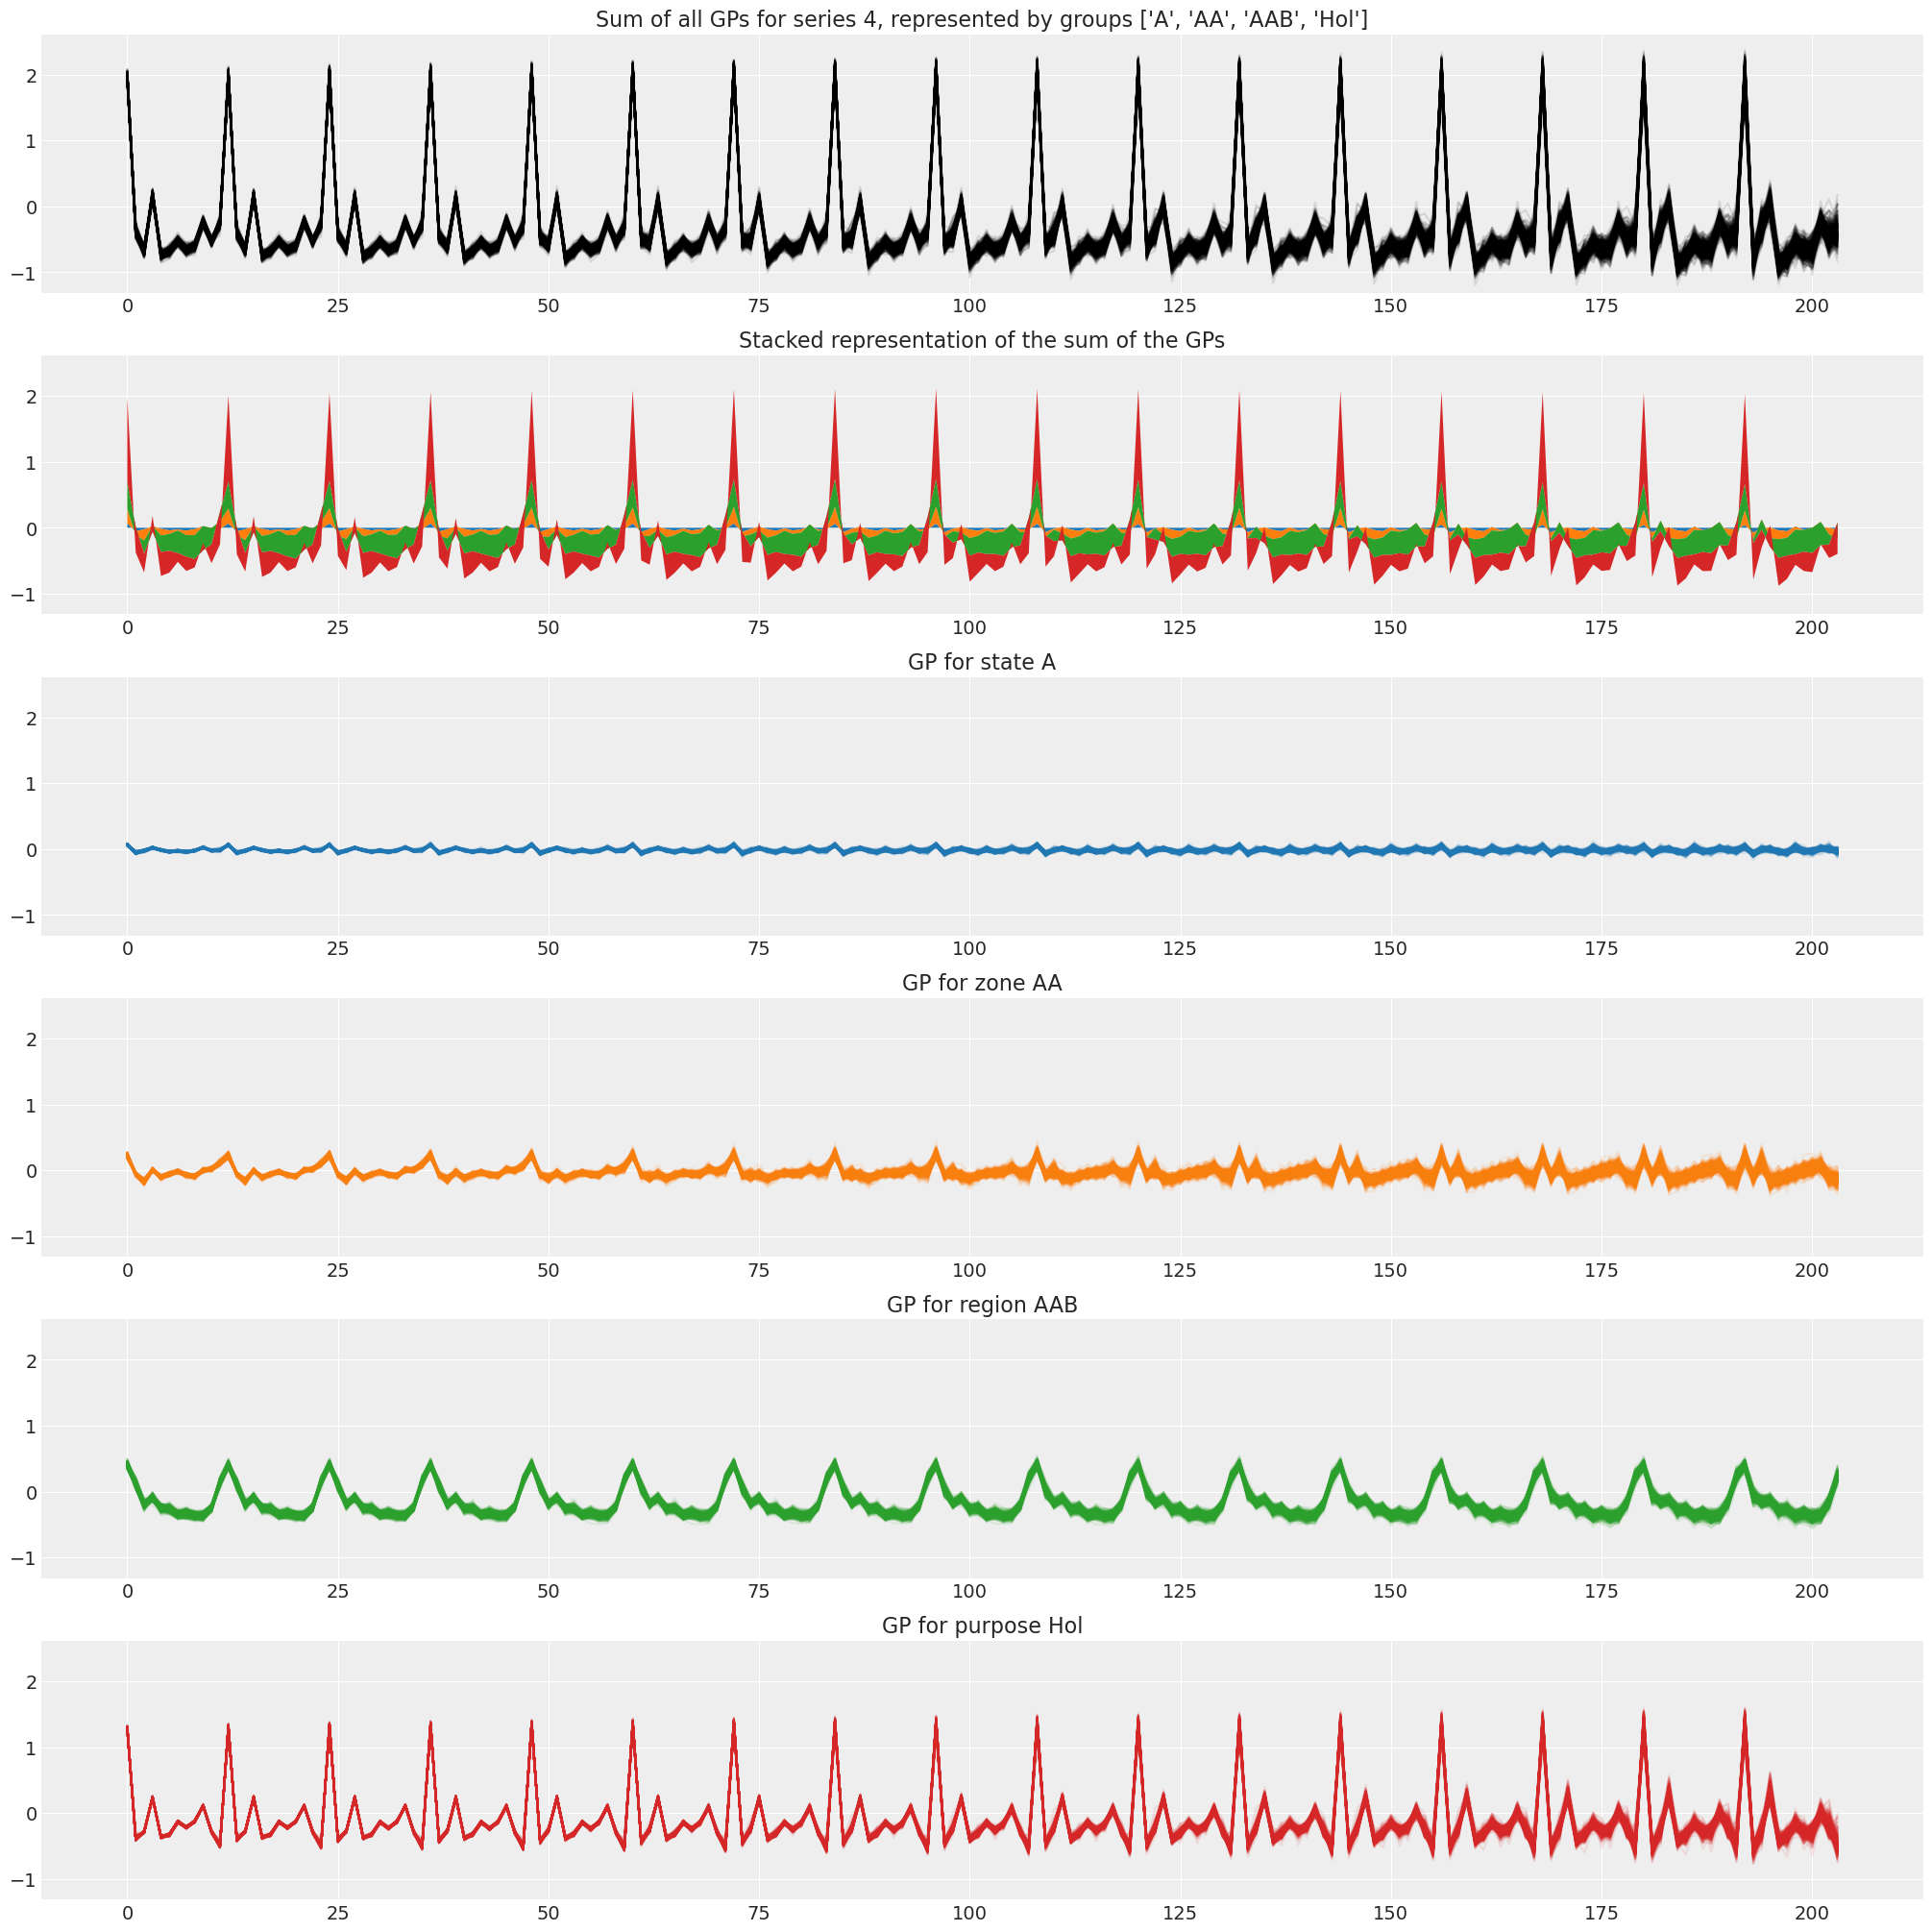

In [15]:
plot_gps_components(series=4, groups=m.g, trace=m.trace_vi_samples)

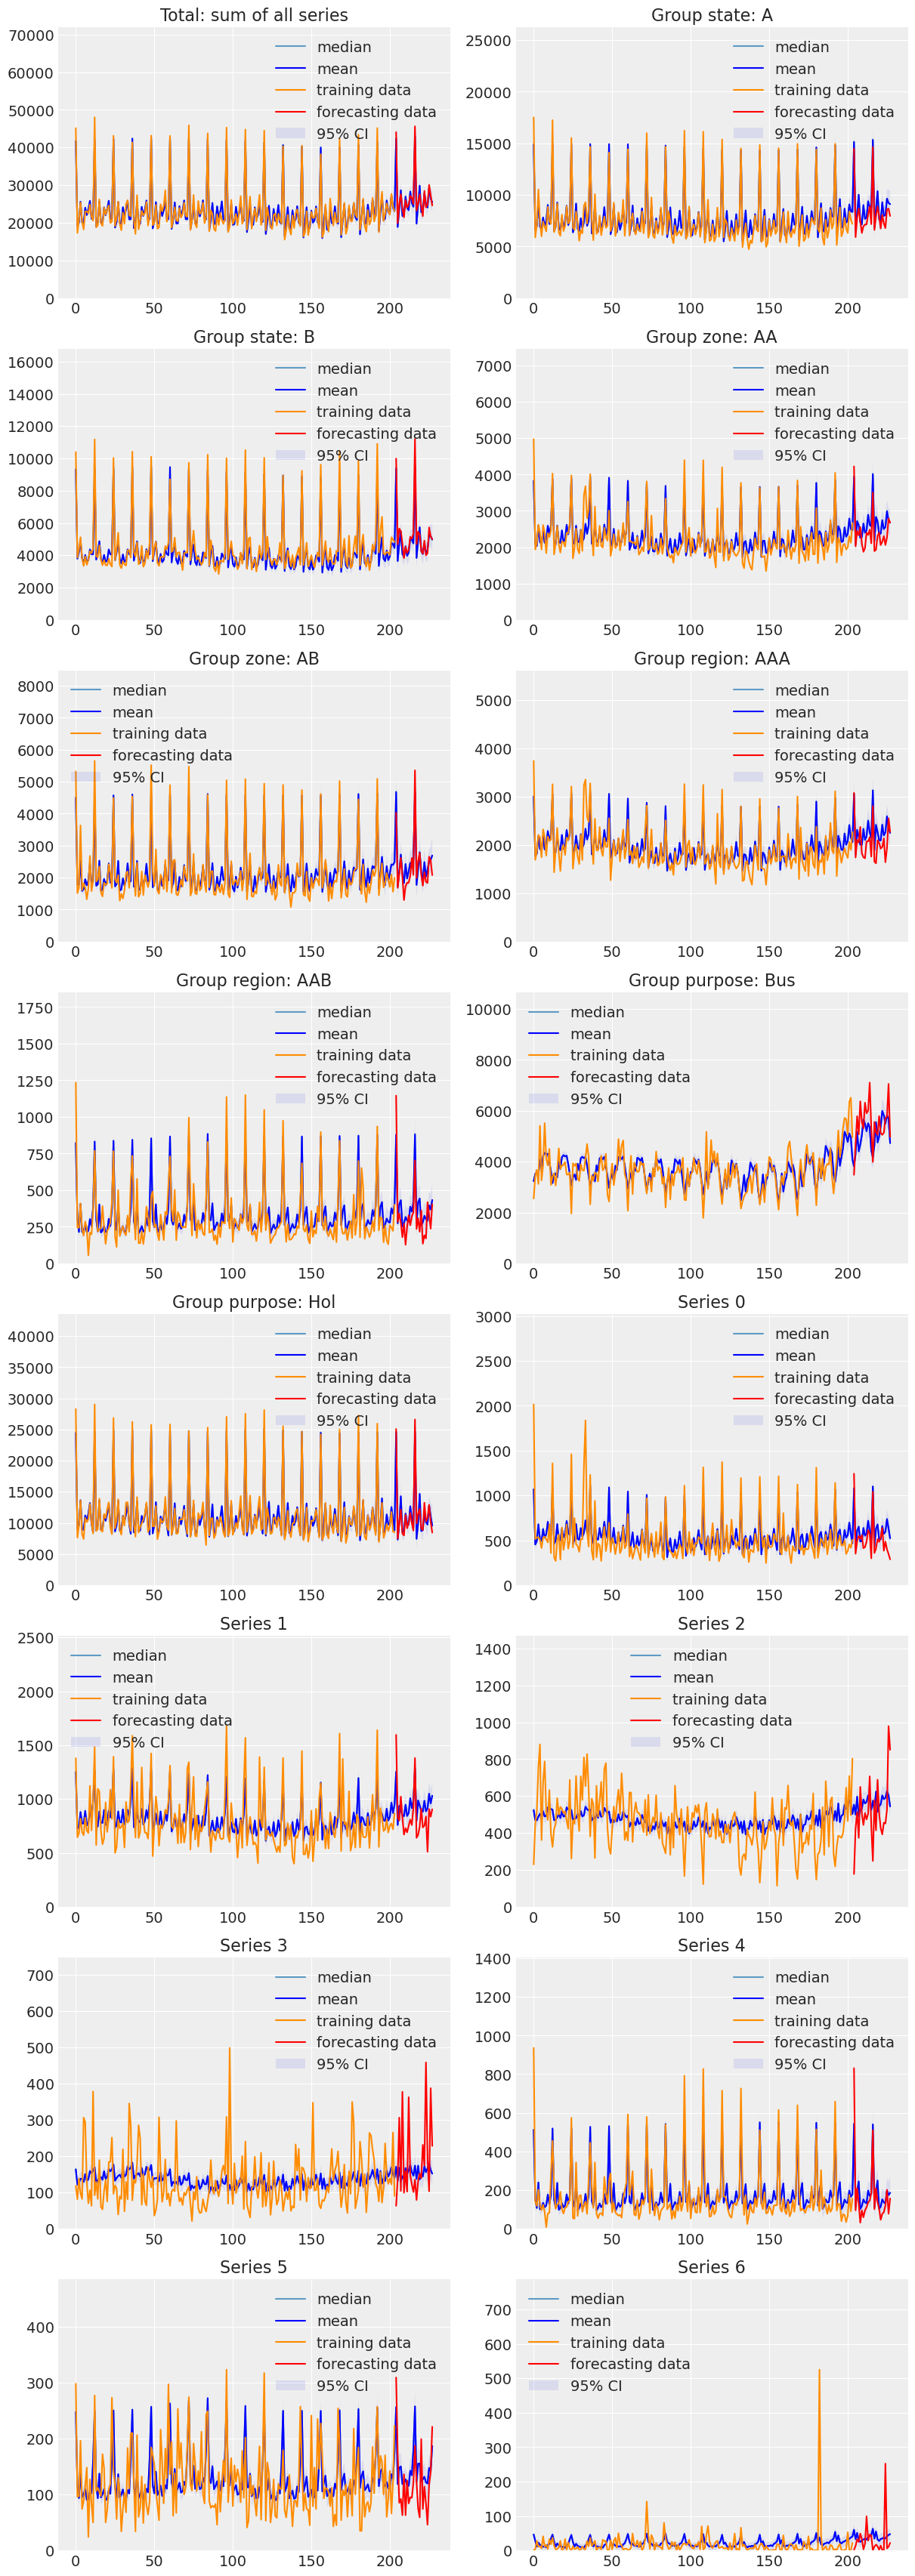

In [11]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [12]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Minibatch - Outside Piecewise Linear w/ Partial pooling

In [ ]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [ ]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

In [ ]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  partial_pool=True,
                  minibatch=[100,20])

In [ ]:
m.fit_vi()

In [ ]:
m.predict()

In [ ]:
plot_elbo(m.trace_vi, 50000)

In [ ]:
plot_gps_components(series=31, groups=m.g, trace=m.trace_vi_samples)

In [ ]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

# Fullrank ADVI

In [2]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing import generate_groups_data_matrix_minibatch, generate_groups_data_matrix, data_transform

class LogLinear(pm.gp.mean.Mean):
    # Log linear mean function to get diminishing returns on the GP mean functions
    # -> adding 1 to avoid inf when X = 0
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(tt.log(X+1), self.b) + self.a)


class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        
        if not self.minibatch:
            # with minibatch X is already a theano variable
            X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 a,
                 changepoints,
                 groups):
        self.a = a
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise + self.a


class HGPforecaster:

    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        log_lin_mean=None,
        likelihood='normal',
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool=False,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.likelihood = likelihood
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool = partial_pool
        self.partial_pool_mean = partial_pool

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.log_lin_mean = log_lin_mean

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        if self.likelihood == 'normal':
            # if likelihood is normal standardize data
            self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            if self.likelihood=='poisson':
                pass
            else:
                # In the case of a normal likelihood we need to define sigma
                self.priors['sigma'] = pm.HalfNormal(
                    'sigma',
                    0.001,
                    shape = self.g['train']['s'])

            if self.piecewise_out:
                if self.likelihood == 'poisson':
                    pass
                else:
                    for group in self.levels:
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group,
                            0.0,
                            0.1)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.1)

                        self.priors["hy_b_%s" %group] = pm.Normal(
                            'hy_b_%s' %group, 
                            0.,
                            0.1,
                            shape = (self.changepoints.shape[0],1))

                        self.priors['hy_a_%s' %group] = pm.Normal(
                            'hy_a_%s' %group,
                            0.1)
                    

                        self.priors["k_%s" %group] = pm.Normal(
                            'k_%s' %group,
                            self.priors["hy_k_%s" %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])
                        self.priors["m_%s"%group] = pm.Normal(
                            'm_%s' %group, 
                            self.priors["hy_m_%s" %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])

                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            self.priors["hy_b_%s" %group],
                            0.01,
                            shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))                            
                            
                            
                        self.priors["a_%s"%group] = pm.Normal(
                            'a_%s' %group, 
                            self.priors['hy_a_%s' %group],
                            0.01,
                            shape = self.g['train']['groups_n'][group])


            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                if self.partial_pool:
                    pass

                else:
                    # Initialization not using partial pooling

                    # Parameters expQuad kernel
                    self.priors["l_t_%s" %group] = pm.InverseGamma(
                        'l_t_%s' %group, 
                        4, 
                        self.g['train']['n'], 
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_t_%s" %group] = pm.HalfNormal(
                        'eta_t_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])

                    # Parameters periodic kernel
                    self.priors["l_p_%s" %group] = pm.HalfNormal(
                        'l_p_%s' %group, 
                        0.5,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_p_%s" %group] = pm.HalfNormal(
                        'eta_p_%s' %group, 
                        1.5, 
                        shape = self.g['train']['groups_n'][group])

                    # Parameters white noise kernel
                    self.priors["sigma_%s" %group] = pm.HalfNormal(
                        'sigma_%s' %group, 
                        0.001,
                        shape = self.g['train']['groups_n'][group])





    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group


                    mu_func = pm.gp.mean.Zero()

                    # cov function for the GP with specific parameters per group
                    cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                            + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                            + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    pass
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    # defining a poisson likelihood
                    if self.piecewise_out:
                        pass
                    else:
                        # not using a piecewise linear function outside of the GPs
                        self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'])
                else:
                    if self.piecewise_out:
                        # normal likelihood with a piecewise function summed
                        piece_={}
                        for group in self.levels:
                            piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                            m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                            b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                            a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                            changepoints = self.changepoints,
                                                            groups = self.g).build(self.X)
                        
                        piece = sum(piece_.values())
                        self.y_pred = pm.Normal('y_pred', 
                            mu=self.f + piece, 
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])
                    else:
                        # normal likelihood without minibatch
                        self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'],
                                observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.likelihood=='poisson':
                # defining a poisson likelihood
                if self.piecewise_out:
                    pass
            else:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(self.X)

                    piece = sum(piece_.values())
                    self.prior_like = pm.Normal('prior_like', 
                        mu=piece + self.f, 
                        sd=self.priors['sigma'],
                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
                else:
                    pass
            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='fullrank_advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            if self.likelihood == 'normal':
                self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.likelihood=='poisson':
                pass
            else:
                if self.piecewise_out:
                    piece_={}
                    for group in self.levels:
                        piece_[group] = OutPiecewiseLinearChangepoints(k = self.priors["k_%s" %group][self.g['train']['groups_idx'][group]],
                                                        m = self.priors["m_%s" %group][self.g['train']['groups_idx'][group]],
                                                        b = self.priors['b_%s' %group][:,self.g['train']['groups_idx'][group]],
                                                        a = self.priors["a_%s" %group][self.g['train']['groups_idx'][group]],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(X_new)

                    piece = sum(piece_.values())
                    y_pred_new = pm.Normal("y_pred_new", 
                                    mu=f_ + piece,
                                    sd=self.priors['sigma'],
                                    shape=(n_new, self.g['predict']['s']))
                else:
                    pass
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                pass
        # backtransform the data and predictions to the original scale
        if self.likelihood == 'normal':
            if self.minibatch:   
                self.g['train']['data'] = self.g['train']['full_data'] 
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
            else:
                self.g = self.dt.inv_transf_train()
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [3]:
data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)
data = data.round()

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

In [4]:
groups = generate_groups_data_flat(y = data, 
                               groups_input = groups_input, 
                               seasonality=12, 
                               h=24)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [5]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [6]:
#m.prior_predictive_checks()
#visualize_prior(groups, m.prior_checks, 8)

In [ ]:
m.fit_vi()

Fitting model...


In [ ]:
m.predict()

In [ ]:
plot_elbo(m.trace_vi, 50000)

In [ ]:
plot_gps_components(series=4, groups=m.g, trace=m.trace_vi_samples)

In [ ]:
visualize_predict(groups, m.pred_samples_predict, 8)

In [ ]:
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)